# Radiomic Prediction of Tumor Grade and Overall Survival from the BraTS Glioma Dataset: An Exploratory Analysis of Dimensionality Reduction Techniques and Machine Learning Classifiers

## Kareem Wahid
## Colen Lab, MD Anderson Cancer Center
## Last updated: July 31, 2017

This notebook contains all code corresponding to "Radiomic Prediction of Tumor Grade and Overall Survival from the BraTS Glioma Dataset: An Exploratory Analysis of Dimensionality Reduction Techniques and Machine Learning Classifiers", a study conducted during the summer of 2017 for the Colen Lab at MD Anderson Cancer Center. It is dependent on output files generated by Pyradiomics that are located in the corresponding github folder located at: . All code should be run in order. Model building takes approx 2 hours for grade classification task and 1 hour for survival classification task. 

## Dependencies

In [8]:
# Import all dependencies 

# Classifiers
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Pre-processing/Feature selection 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, KernelPCA, TruncatedSVD, NMF

# Model building 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, LeaveOneOut, KFold
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

# Stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Misc. 
import pandas as pd
pd.set_option('display.max_columns', None) # See all columns
pd.set_option('display.max_rows', None) # See all rows 
import numpy as np
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True) 
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Grade Classification Task ---

## Import and clean data 

In [9]:
# Import datasets for phenotypes 
radiomic_raw_necrosis = pd.read_csv('grades_t1ce_label1_norm_binpt1_Wavelet_radiomics.csv') # label 1 on T1ce norm bin wavelet
radiomic_raw_edema = pd.read_csv('grades_flair_label2_norm_binpt1_Wavelet_radiomics.csv') # label 2 on FLAIR norm bin wavelet
radiomic_raw_enhancing = pd.read_csv('grades_t1ce_label4_norm_binpt1_Wavelet_radiomics.csv') # label 4 on T1ce norm bin wavelet

# Add suffixes to phenotypes 
radiomic_raw_necrosis = radiomic_raw_necrosis.add_suffix('_necrosis') 
radiomic_raw_necrosis=radiomic_raw_necrosis.rename(columns = {'Grade_necrosis':'Grade'}) # Keep only one column for grade
radiomic_raw_edema = radiomic_raw_edema.add_suffix('_edema')
radiomic_raw_enhancing = radiomic_raw_enhancing.add_suffix('_enhancing')

In [10]:
radiomic_raw = pd.concat([radiomic_raw_necrosis, radiomic_raw_edema, radiomic_raw_enhancing], axis=1, join='inner') # Join phenotypes into one DataFrame 
radiomic_raw.tail()

Brats17ID_necrosis Grade               Image_necrosis  \
280  Brats17_TCIA_644_1   Low  Brats17_TCIA_644_1_t1ce.nii   
281  Brats17_TCIA_645_1   Low  Brats17_TCIA_645_1_t1ce.nii   
282  Brats17_TCIA_650_1   Low  Brats17_TCIA_650_1_t1ce.nii   
283  Brats17_TCIA_653_1   Low  Brats17_TCIA_653_1_t1ce.nii   
284  Brats17_TCIA_654_1   Low  Brats17_TCIA_654_1_t1ce.nii   

                  Mask_necrosis general_info_BoundingBox_necrosis  \
280  Brats17_TCIA_644_1_seg.nii          (92, 50, 45, 62, 88, 71)   
281  Brats17_TCIA_645_1_seg.nii         (66, 110, 36, 54, 75, 53)   
282  Brats17_TCIA_650_1_seg.nii        (102, 141, 15, 28, 32, 29)   
283  Brats17_TCIA_653_1_seg.nii        (143, 76, 102, 18, 31, 19)   
284  Brats17_TCIA_654_1_seg.nii          (60, 40, 61, 71, 84, 68)   

                 general_info_GeneralSettings_necrosis  \
280  {'distances': [1], 'additionalInfo': True, 'en...   
281  {'distances': [1], 'additionalInfo': True, 'en...   
282  {'distances': [1], 'additionalInfo': True, 'en...   
283  {'distances': [1], 'additionalInfo': True, 'en...   
284  {'distances': [1], 'additionalInfo': True, 'en...   

              general_info_ImageHash_necrosis  \
280  507bec47ac46c8d5ffd0bc7e18047d7e8fb2211d   
281  591b153d0ce0735775fc5c0d4b0fa1cd374fc431   
282  7269e4fd5a22ff2ec0b7142ecb2a6e8f1b879504   
283  146ad42e074bf4219372cb402d16827e30e1d884   
284  e802c9798d8c27b7caa41d77e4953f388830e0c7   

    general_info_ImageSpacing_necrosis general_info_InputImages_necrosis  \
280                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   
281                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   
282                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   
283                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   
284                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   

               general_info_MaskHash_necrosis general_info_Version_necrosis  \
280  1c32fca6c7d9381a4c9eb49863e78f6194f468a8         1.2.0.post19+gf2cbd3d   
281  cf86433a7591fed06726f4ed73ba8f1b09cc9104         1.2.0.post19+gf2cbd3d   
282  43f7f5f64ccb2e93e56fefbec45832ab012a069e         1.2.0.post19+gf2cbd3d   
283  476dacb3173fb8824a9d6185780545b1f8480af3         1.2.0.post19+gf2cbd3d   
284  ae7596bb8f19d3f71686ad639cece3c45fa7c75a         1.2.0.post19+gf2cbd3d   

     general_info_VolumeNum_necrosis  general_info_VoxelNum_necrosis  \
280                             12.0                         65330.0   
281                              3.0                         45782.0   
282                              1.0                          9634.0   
283                             16.0                           437.0   
284                              4.0                        134624.0   

     original_shape_Maximum3DDiameter_necrosis  \
280                                  90.216406   
281                                  75.405570   
282                                  33.301652   
283                                  32.939338   
284                                  87.960218   

     original_shape_Compactness2_necrosis  \
280                              0.030609   
281                              0.108969   
282                              0.278851   
283                              0.026067   
284                              0.071096   

     original_shape_Maximum2DDiameterSlice_necrosis  \
280                                       75.106591   
281                                       73.061618   
282                                       31.400637   
283                                       19.235384   
284                                       82.565126   

     original_shape_Sphericity_necrosis  original_shape_MinorAxis_necrosis  \
280                            0.312812                          55.386019   
281                            0.477640                          41.963879   
282                            0.653317                          25.520

In [11]:
radiomic_raw.shape

(285, 2193)

In [12]:
# Delete all unnecessary columns and rows
radiomic_filtered = radiomic_raw[np.isfinite(radiomic_raw['original_glszm_SmallAreaLowGrayLevelEmphasis_necrosis'])] # drop rows wiw NaN values
radiomic_filtered = radiomic_filtered[np.isfinite(radiomic_filtered['original_glszm_SmallAreaLowGrayLevelEmphasis_edema'])]
radiomic_filtered = radiomic_filtered[np.isfinite(radiomic_filtered['original_glszm_SmallAreaLowGrayLevelEmphasis_enhancing'])]


radiomic_filtered.drop(
    [
        col for col in radiomic_filtered.columns if # drop columns with unnesccsary info 
        'Brats17ID' in col or
        'Image' in col or
        'Mask' in col or
        'general_info' in col or 
        'Grade_edema' in col or
        'Grade_enhancing' in col
    ],
    axis=1,inplace=True
)

radiomic_filtered.tail()

Grade  original_shape_Maximum3DDiameter_necrosis  \
278   Low                                  39.749214   
279   Low                                  93.171884   
282   Low                                  33.301652   
283   Low                                  32.939338   
284   Low                                  87.960218   

     original_shape_Compactness2_necrosis  \
278                              0.098839   
279                              0.168626   
282                              0.278851   
283                              0.026067   
284                              0.071096   

     original_shape_Maximum2DDiameterSlice_necrosis  \
278                                       39.293765   
279                                       89.453899   
282                                       31.400637   
283                                       19.235384   
284                                       82.565126   

     original_shape_Sphericity_necrosis  original_shape_MinorAxis_necrosis  \
278                            0.462355                          26.095632   
279                            0.552470                          63.763914   
282                            0.653317                          25.520621   
283                            0.296505                          19.867693   
284                            0.414269                          61.525865   

     original_shape_Compactness1_necrosis  original_shape_Elongation_necrosis  \
278                              0.016679                            0.853657   
279                              0.021785                            0.792166   
282                              0.028015                            0.941683   
283                              0.008565                            0.859293   
284                              0.014146                            0.853560   

     original_shape_SurfaceVolumeRatio_necrosis  \
278                                    0.545738   
279                                    0.158447   
282                                    0.347876   
283                                    2.149272   
284                                    0.227769   

     original_shape_Volume_necrosis  \
278                          7040.0   
279                        168606.0   
282                          9634.0   
283                           437.0   
284                        134624.0   

     original_shape_SphericalDisproportion_necrosis  \
278                                        2.162840   
279                                        1.810054   
282                                        1.530649   
283                                        3.372623   
284                                        2.413889   

     original_shape_MajorAxis_necrosis  original_shape_LeastAxis_necrosis  \
278                          30.569235                          16.323958   
279                          80.493159                          53.433697   
282                          27.101072                          20.707164   
283                          23.120976                          10.934087   
284                          72.081500                          54.127716   

     original_shape_Flatness_necrosis  original_shape_SurfaceArea_necrosis  \
278                          0.534000                          3841.997025   
279                          0.663829                         26715.155008   
282                          0.764072                          3351.436318   
283                          0.472908                           939.231990   
284                          0.750924                         30663.124308   

     original_shape_Maximum2DDiameterColumn_necrosis  \
278                                        33.541020   
279                                        78.294317   
282                                        31.622777   
283                                        21.213203   
284                     

In [13]:
radiomic_filtered.shape

(235, 2155)

In [14]:
# Set positive and negative classes so you can use in classifiers 
radiomic_filtered.loc[radiomic_filtered.Grade == 'Low', 'Grade'] = 0
radiomic_filtered.loc[radiomic_filtered.Grade == 'High', 'Grade'] = 1
radiomic_filtered[['Grade']] = radiomic_filtered[['Grade']].apply(pd.to_numeric)
radiomic_filtered.tail()

Grade  original_shape_Maximum3DDiameter_necrosis  \
278      0                                  39.749214   
279      0                                  93.171884   
282      0                                  33.301652   
283      0                                  32.939338   
284      0                                  87.960218   

     original_shape_Compactness2_necrosis  \
278                              0.098839   
279                              0.168626   
282                              0.278851   
283                              0.026067   
284                              0.071096   

     original_shape_Maximum2DDiameterSlice_necrosis  \
278                                       39.293765   
279                                       89.453899   
282                                       31.400637   
283                                       19.235384   
284                                       82.565126   

     original_shape_Sphericity_necrosis  original_shape_MinorAxis_necrosis  \
278                            0.462355                          26.095632   
279                            0.552470                          63.763914   
282                            0.653317                          25.520621   
283                            0.296505                          19.867693   
284                            0.414269                          61.525865   

     original_shape_Compactness1_necrosis  original_shape_Elongation_necrosis  \
278                              0.016679                            0.853657   
279                              0.021785                            0.792166   
282                              0.028015                            0.941683   
283                              0.008565                            0.859293   
284                              0.014146                            0.853560   

     original_shape_SurfaceVolumeRatio_necrosis  \
278                                    0.545738   
279                                    0.158447   
282                                    0.347876   
283                                    2.149272   
284                                    0.227769   

     original_shape_Volume_necrosis  \
278                          7040.0   
279                        168606.0   
282                          9634.0   
283                           437.0   
284                        134624.0   

     original_shape_SphericalDisproportion_necrosis  \
278                                        2.162840   
279                                        1.810054   
282                                        1.530649   
283                                        3.372623   
284                                        2.413889   

     original_shape_MajorAxis_necrosis  original_shape_LeastAxis_necrosis  \
278                          30.569235                          16.323958   
279                          80.493159                          53.433697   
282                          27.101072                          20.707164   
283                          23.120976                          10.934087   
284                          72.081500                          54.127716   

     original_shape_Flatness_necrosis  original_shape_SurfaceArea_necrosis  \
278                          0.534000                          3841.997025   
279                          0.663829                         26715.155008   
282                          0.764072                          3351.436318   
283                          0.472908                           939.231990   
284                          0.750924                         30663.124308   

     original_shape_Maximum2DDiameterColumn_necrosis  \
278                                        33.541020   
279                                        78.294317   
282                                        31.622777   
283                                        21.213203   
284                

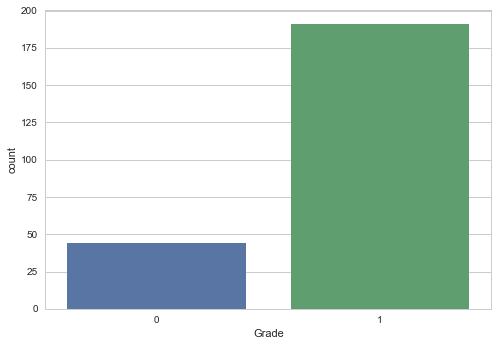

In [15]:
# Visualize counts of classes
gradebox = sns.countplot(x="Grade", data = radiomic_filtered)
gradebox.set_xlabel('Grade')
fig = gradebox.get_figure()

## Model building

In [16]:
%%time

master_df = pd.DataFrame(columns = [
    'CLF', 'FSM', 'DN', 
    'AUC_mean', 'AUC_median', 'AUC_std',
    'ACC_mean', 'ACC_median', 'ACC_std',
    'SENS_mean', 'SENS_median', 'SENS_std'
]) # create dataframe where all values will be stored for each combo

clf_A = DecisionTreeClassifier(random_state=0)  # Ensure all classifiers are set to random states if applicable 
clf_B = RandomForestClassifier(random_state=0)
clf_C = BaggingClassifier(random_state=0)
clf_D = GradientBoostingClassifier(random_state=0)
clf_E = GaussianNB()
clf_F = MLPClassifier(random_state=0)
clf_G = SVC(random_state=0, probability=True) # Need probability to be true so can use AUC score 
clf_H = LogisticRegression(random_state=0)
clf_I = KNeighborsClassifier()
clf_list = [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I]

dimension_number_list = range(1,17,2)

score_func_list = ['FILT', 'PCA', 'KPCA','ICA', 'FA']

for clf in clf_list:
    for score_func in score_func_list:
        for dimension_number in dimension_number_list:
            
            auc_list = [] # Empty lists to be filled 
            accuracy_list = []
            sensitivity_list = []
            
            # Split dataset randomly 100 times 
            for i in range(100):
                train, test = train_test_split(radiomic_filtered, test_size = 0.2, random_state=i) 
                survival_classes_train = train['Grade']  
                features_train = train.drop('Grade', axis = 1)
                survival_classes_test = test['Grade'] 
                features_test = test.drop('Grade', axis = 1)
        
                # Perform Synthetic Upsampling on training set only  
                sm = SMOTE(random_state=0)
                features_train, survival_classes_train = sm.fit_sample(features_train, survival_classes_train)
                
                if score_func == 'FILT':
                    clf_pipe = make_pipeline(StandardScaler(), SelectKBest(k=30), clf) # Univariate filtering feature selection method (ANOVA F-score)
                elif score_func == 'PCA':
                    clf_pipe = make_pipeline(StandardScaler(), PCA(n_components=dimension_number, random_state=0), clf) # Ensure all dimensionality reduction methods are set to random states 
                elif score_func == 'KPCA':
                    clf_pipe = make_pipeline(StandardScaler(), KernelPCA(n_components=dimension_number, kernel='sigmoid', random_state=0), clf)
                elif score_func == 'ICA':
                    clf_pipe = make_pipeline(StandardScaler(), FastICA(n_components=dimension_number, random_state=0), clf)
                elif score_func == 'FA':
                    clf_pipe = make_pipeline(StandardScaler(), FactorAnalysis(n_components=dimension_number, random_state=0), clf)
                    
                clf_pipe.fit(features_train, survival_classes_train) # fit with training data only  
                
                auc_list.append(roc_auc_score(survival_classes_test, clf_pipe.predict_proba(features_test)[:,1])) # AUC score NOTE: Predict proba returns a probability per class ("0", "1") so need [:,1] to get positive class
                accuracy_list.append(accuracy_score(survival_classes_test, clf_pipe.predict(features_test))) # accuracy score
                sensitivity_list.append(recall_score(survival_classes_test, clf_pipe.predict(features_test))) # sensitivity list 
                
            master_df = master_df.append(
                {
                'CLF': str(clf.__class__.__name__), # classifier name
                'FSM': score_func, # score function name 
                'DN': dimension_number, # number of dimensions 
                'AUC_mean': np.mean(auc_list), 
                'AUC_median': np.median(auc_list),
                'AUC_std': np.std(auc_list),
                'RSD': np.std(auc_list)/np.mean(auc_list)*100, # RSD as defined by Parmer et al 2015 
                'ACC_mean': np.mean(accuracy_list),
                'ACC_median': np.median(accuracy_list),
                'ACC_std': np.std(accuracy_list),
                'SENS_mean': np.mean(sensitivity_list),
                'SENS_median': np.median(sensitivity_list),
                'SENS_std': np.std(sensitivity_list)             
                }, ignore_index = True)
            #print master_df #debugging 
            if score_func == 'FILT':
                break 

/Users/kareemwahid/anaconda/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/kareemwahid/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


CPU times: user 3h 44min 49s, sys: 15min 57s, total: 4h 46s
Wall time: 2h 20min 4s


In [17]:
master_df.head()

CLF   FSM DN  AUC_mean  AUC_median   AUC_std  ACC_mean  \
0  DecisionTreeClassifier  FILT  1  0.820552    0.832883  0.077584  0.871277   
1  DecisionTreeClassifier   PCA  1  0.636974    0.627417  0.082062  0.652766   
2  DecisionTreeClassifier   PCA  3  0.682251    0.675505  0.085416  0.737872   
3  DecisionTreeClassifier   PCA  5  0.752285    0.757070  0.093158  0.818085   
4  DecisionTreeClassifier   PCA  7  0.764649    0.765559  0.095884  0.831064   

   ACC_median   ACC_std  SENS_mean  SENS_median  SENS_std        RSD  
0    0.872340  0.044056   0.907364     0.903600  0.046370   9.455079  
1    0.648936  0.069979   0.663493     0.666667  0.085201  12.883112  
2    0.723404  0.068276   0.774317     0.773214  0.077166  12.519800  
3    0.819149  0.055186   0.864689     0.868421  0.059955  12.383313  
4    0.829787  0.054976   0.877064     0.869694  0.054957  12.539636

## Heatmaps

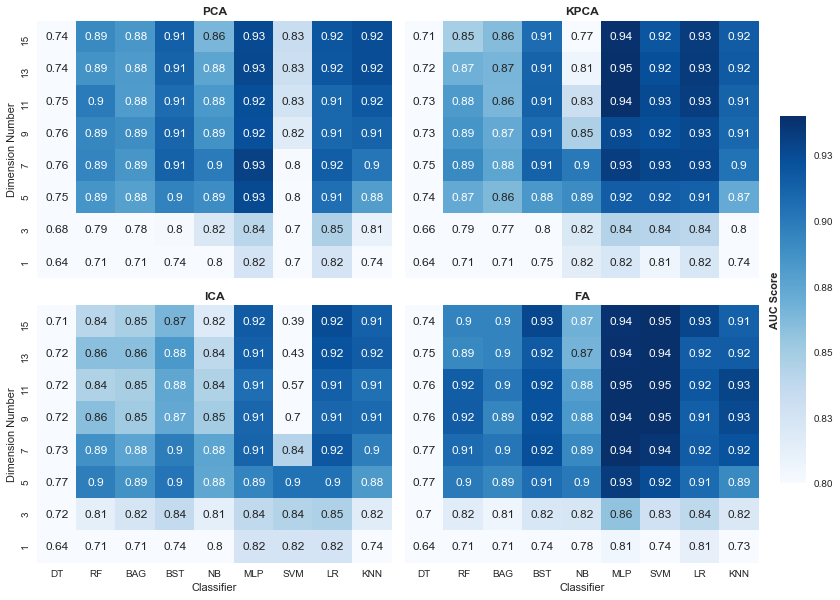

In [52]:
# Predictive performance corresponding to classification methods (in columns) 
# and the number of dimensions (in rows) for each dimensionality reduction 
# method for grade classification task.

labels = ['DT', 'RF', 'BAG', 'BST', 'NB', 'MLP', 'SVM', 'LR', 'KNN']

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8.5))
cbar_ax = fig.add_axes([.91, .2, .03, .6])

fsm_list = ['PCA', 'KPCA','ICA', 'FA']
for i, (fsm, ax) in enumerate(zip(fsm_list, axn.flat)):
    dimensionality_reduction_heatmap_df = pd.DataFrame(index = dimension_number_list, columns = [clf.__class__.__name__ for clf in clf_list])
    for dimension_number in dimension_number_list:
        for clf in clf_list:
            dimensionality_reduction_heatmap_df.set_value(dimension_number, clf.__class__.__name__, master_df[(master_df['DN'] == dimension_number) &
                                                                      (master_df['FSM'] == fsm) &
                                                                     (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
    dimensionality_reduction_heatmap_df = dimensionality_reduction_heatmap_df[dimensionality_reduction_heatmap_df.columns].astype(float)
    heatmap = sns.heatmap(dimensionality_reduction_heatmap_df, ax=ax, cmap = 'Blues', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.80, vmax=0.94, xticklabels=labels, annot= True, cbar=i == 0, cbar_ax=None if i else cbar_ax)
    heatmap.invert_yaxis()
    if fsm == 'PCA':
        ax.set_title('PCA',fontweight='bold')
        heatmap.set(ylabel='Dimension Number')
        ax.collections[0].colorbar.set_label("AUC Score", fontweight='bold', labelpad=-63)
    elif fsm == 'KPCA':
        ax.set_title('KPCA', fontweight='bold')
    elif fsm == 'ICA':
        ax.set_title('ICA', fontweight='bold')
        heatmap.set(xlabel='Classifier', ylabel='Dimension Number')
    elif fsm == 'FA':
        ax.set_title('FA', fontweight='bold')
        heatmap.set(xlabel='Classifier')   
fig.tight_layout(rect=[0, 0, .9, 1])
#plt.savefig('grade_heatmap_all.pdf', bbox_inches='tight') # uncomment to save figure

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

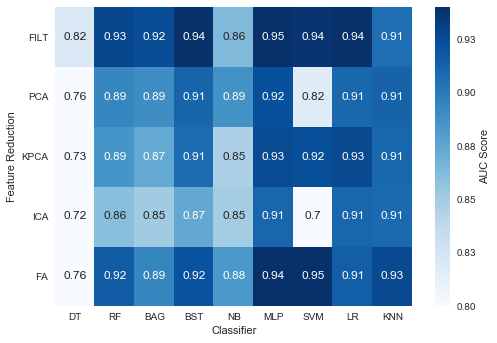

In [19]:
# Heatmap of dimensionality reduction techniques only

master_heatmap_df = pd.DataFrame(index = score_func_list, columns = [clf.__class__.__name__ for clf in clf_list])

for score_func in score_func_list:
    for clf in clf_list: 
        if score_func == 'FILT':
            master_heatmap_df.set_value(score_func, clf.__class__.__name__, master_df[(master_df['DN'] == 1) &
                                                            (master_df['FSM'] == score_func) &
                                                            (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            master_heatmap_df = master_heatmap_df[master_heatmap_df.columns].astype(float)
        else:
            master_heatmap_df.set_value(score_func, clf.__class__.__name__, master_df[(master_df['DN'] == 9) &
                                                            (master_df['FSM'] == score_func) &
                                                            (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            master_heatmap_df = master_heatmap_df[master_heatmap_df.columns].astype(float)

heatmap = sns.heatmap(master_heatmap_df, cmap = 'Blues', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.80, vmax=0.94, xticklabels=labels, annot= True)
heatmap.set(xlabel='Classifier', ylabel='Feature Reduction') 
plt.yticks(rotation=0)

In [20]:
%%time
### Diameter features  

volume_df = pd.DataFrame(columns = [
    'CLF', 'FSM', 'DN', 
    'AUC_mean', 'AUC_median', 'AUC_std',
    'ACC_mean', 'ACC_median', 'ACC_std',
    'SENS_mean', 'SENS_median', 'SENS_std'
]) # create dataframe where all values will be stored for each combo)

radiomic_filtered_copy = radiomic_filtered.copy()

radiomic_filtered_copy = radiomic_filtered_copy[['Grade',
                                                 'original_shape_Maximum2DDiameterSlice_necrosis', 
                                                 'original_shape_Maximum2DDiameterSlice_edema', 
                                                 'original_shape_Maximum2DDiameterSlice_enhancing'
                                                ]] # Radiologist approx

for clf in clf_list:
    auc_list = []
    accuracy_list = []
    sensitivity_list = []
    
    for i in range(100):
        train2, test2 = train_test_split(radiomic_filtered_copy, test_size = 0.2, random_state=i) 
        survival_classes_train2 = train2['Grade']  
        features_train2 = train2.drop('Grade', axis = 1)
        survival_classes_test2 = test2['Grade'] 
        features_test2 = test2.drop('Grade', axis = 1)
        
        # SMOTE
        sm = SMOTE(random_state=0)
        features_train2, survival_classes_train2 = sm.fit_sample(features_train2, survival_classes_train2)
        
        clf_pipe = make_pipeline(StandardScaler(), clf)
        clf_pipe.fit(features_train2, survival_classes_train2)
        
        auc_list.append(roc_auc_score(survival_classes_test2, clf_pipe.predict_proba(features_test2)[:,1])) # AUC score NOTE: Predict proba returns a probability per class ("0", "1") so need [:,1] to get positive class     
        accuracy_list.append(accuracy_score(survival_classes_test2, clf_pipe.predict(features_test2))) # accuracy score 
        sensitivity_list.append(recall_score(survival_classes_test2, clf_pipe.predict(features_test2))) # sensitivity list 
                
    volume_df = volume_df.append({
                'CLF': str(clf.__class__.__name__), # classifier name
                'FSM': 'DIAM', # score function name 
                'DN': 1, # number of dimensions 
                'AUC_mean': np.mean(auc_list), 
                'AUC_median': np.median(auc_list),
                'AUC_std': np.std(auc_list),
                'RSD': np.std(auc_list)/np.mean(auc_list)*100, # RSD as defined by Parmer et al 2015 
                'ACC_mean': np.mean(accuracy_list),
                'ACC_median': np.median(accuracy_list),
                'ACC_std': np.std(accuracy_list),
                'SENS_mean': np.mean(sensitivity_list),
                'SENS_median': np.median(sensitivity_list),
                'SENS_std': np.std(sensitivity_list)             
                }, ignore_index = True)
    #print volume_df #debugging 

CPU times: user 1min 13s, sys: 781 ms, total: 1min 13s
Wall time: 51.2 s


In [21]:
frames = [master_df, volume_df]
merged_df = pd.concat(frames)

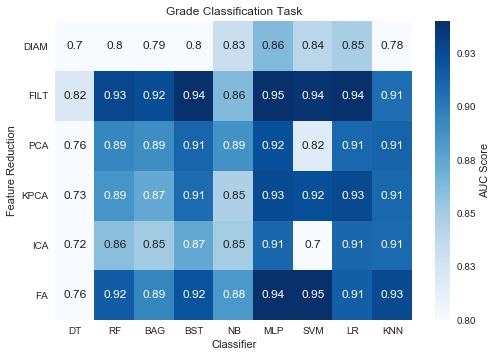

In [51]:
# Heatmap of dimensionality reduction techniques and comparison to diameter

new_score_list2 = ['DIAM', 'FILT', 'PCA', 'KPCA', 'ICA', 'FA']

merged_df_heatmap = pd.DataFrame(index = new_score_list2, columns = [clf.__class__.__name__ for clf in clf_list])

for score_func in new_score_list2:
    for clf in clf_list:
        if score_func == 'FILT' or score_func == 'DIAM':
            merged_df_heatmap.set_value(score_func, clf.__class__.__name__, merged_df[(merged_df['DN'] == 1) &
                                                            (merged_df['FSM'] == score_func) &
                                                            (merged_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            merged_df_heatmap = merged_df_heatmap[merged_df_heatmap.columns].astype(float)
        else:
            merged_df_heatmap.set_value(score_func, clf.__class__.__name__, merged_df[(merged_df['DN'] == 9) &
                                                            (merged_df['FSM'] == score_func) &
                                                            (merged_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            merged_df_heatmap = merged_df_heatmap[merged_df_heatmap.columns].astype(float)

heatmap = sns.heatmap(merged_df_heatmap, cmap = 'Blues', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.80, vmax=0.94, xticklabels=labels, annot= True)
heatmap.set(xlabel='Classifier', ylabel='Feature Reduction') 
plt.yticks(rotation=0)
plt.title('Grade Classification Task')
#plt.savefig('grade_heatmap.pdf', bbox_inches='tight') # uncomment to save figure

## Scatterplot of stability vs. predictive performance 

In [23]:
# Representative DF

new_score_list3 = ['PCA', 'KPCA', 'ICA', 'FA']

rep_df = pd.DataFrame(index = [clf.__class__.__name__ for clf in clf_list], columns = ['AUC_mean', 'RSD'])

for clf in clf_list:
    for column in rep_df.columns:
        rep_df.set_value(clf.__class__.__name__, column, 
                        master_df[( 
                                   (master_df.FSM != 'FILT') & 
                                   (master_df.CLF == clf.__class__.__name__) & 
                                   (master_df.DN == 9))][column].median())
        
rep_df.index.name = 'CLF'
rep_df = rep_df.reset_index()

rep_df

CLF  AUC_mean      RSD
0      DecisionTreeClassifier  0.746638  12.0475
1      RandomForestClassifier   0.88979  6.64686
2           BaggingClassifier  0.881202  7.22635
3  GradientBoostingClassifier  0.909285  5.35265
4                  GaussianNB   0.86696  8.52657
5               MLPClassifier  0.924198   5.3123
6                         SVC  0.869805  6.50497
7          LogisticRegression  0.912637  5.94148
8        KNeighborsClassifier  0.911397  5.73307

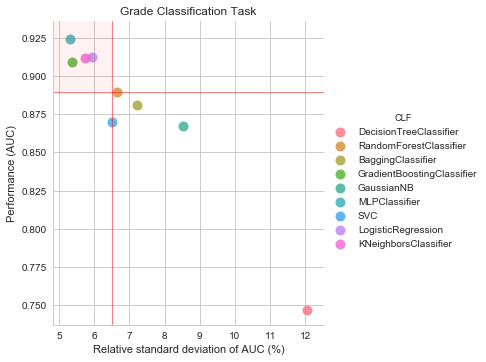

In [56]:
# Representative Scatter 

# Get median values 
AUC_median = rep_df['AUC_mean'].median()
RSD_median = rep_df['RSD'].median()

# Create scatterplot
lm = sns.lmplot(
    x="RSD", y="AUC_mean", hue = 'CLF', data = rep_df, legend = True,
    fit_reg=False, scatter_kws={"s": 100}
)

# Set labels
lm.set_ylabels('Performance (AUC)')
lm.set_xlabels('Relative standard deviation of AUC (%)')

# Get axis extrema to draw lines and boxes
axes = plt.gca()
y_min, y_max = axes.get_ylim()
x_min, x_max = axes.get_xlim()

# Plot median lines for AUC and RSD + highlighted area for classifiers with AUC > median and RSD < median
plt.axhline(y= AUC_median, linewidth=1, color = 'red', alpha=0.5)
plt.axvline(x= RSD_median, linewidth=1, color = 'red', alpha=0.5)
lm.axes[0][0].add_patch(patches.Rectangle((x_min, AUC_median), width= (RSD_median-x_min), height=(y_max-AUC_median),facecolor="red", alpha = 0.05))
plt.title('Grade Classification Task')
#plt.savefig("grade_scatter.pdf", bbox_inches='tight') # uncomment to save figure

## ANOVA

In [25]:
# Fit linear model 
cw_lm = smf.ols(
    'AUC_mean ~ C(CLF) + C(FSM) + C(DN) + C(CLF)*C(DN) + \
    C(FSM)*C(DN) + C(CLF)*C(FSM)', 
    data=master_df[(master_df.FSM != 'FILT')] # Drop FILT  #Specify C for Categorical
).fit() 

# Create ANOVA from linear model 
anova = anova_lm(cw_lm, typ=2)
anova.index.name = 'Experimental Factors'
anova.reset_index(inplace=True)
anova['sum_sq'] = anova['sum_sq'].apply(lambda x: (x / anova['sum_sq'].sum())*100) # Tranform sum sq to % variance
anova = anova.rename(columns={'sum_sq': '% Variance'}) # Rename to variance 

anova 

Experimental Factors  % Variance     df          F        PR(>F)
0               C(CLF)   36.393001    8.0  60.119487  2.188894e-45
1               C(FSM)    3.098637    3.0  13.650130  5.189346e-08
2                C(DN)   27.893836    7.0  52.662029  3.488164e-39
3         C(CLF):C(DN)    5.953500   56.0   1.404985  5.125454e-02
4         C(FSM):C(DN)    3.557652   21.0   2.238884  2.537633e-03
5        C(CLF):C(FSM)   10.391140   24.0   5.721888  2.263063e-12
6             Residual   12.712235  168.0        NaN           NaN

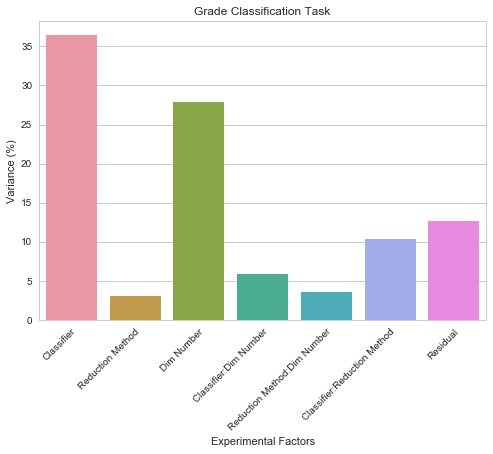

In [26]:
# Creat bar plot for ANOVA factors 
anovaplot = sns.barplot(x="Experimental Factors", y="% Variance", data=anova)

# Change labels 
anovaplot.set_ylabel('Variance (%)')
anovaplot.set_xticklabels(['Classifier', 'Reduction Method', 'Dim Number', 'Classifier:Dim Number', \
                           'Reduction Method:Dim Number', 'Classifier:Reduction Method', 'Residual'], ha='right', rotation=45, rotation_mode = 'anchor')

plt.title('Grade Classification Task')
fig = anovaplot.get_figure()
#fig.savefig("grade_ANOVA.pdf", bbox_inches='tight') # uncomment to save figure

# --- Survival Classification Task ---

## Import and clean data 

In [27]:
# Import datasets for phenotypes 
s_radiomic_raw_necrosis = pd.read_csv('Survival_t1ce_label1_norm_binpt1_Wavelet_radiomics_output.csv') # label 1 on T1ce norm bin wavelet
s_radiomic_raw_edema = pd.read_csv('Survival_flair_label2_norm_binpt1_Wavelet_radiomics.csv') # label 2 on FLAIR norm bin wavelet
s_radiomic_raw_enhancing = pd.read_csv('Survival_t1ce_label4_norm_binpt1_Wavelet_radiomics_output.csv') # label 4 on T1ce norm bin wavelet

# Add suffixes to phenotypes 
s_radiomic_raw_necrosis = s_radiomic_raw_necrosis.add_suffix('_necrosis')
s_radiomic_raw_necrosis= s_radiomic_raw_necrosis.rename(columns = {'Survival_necrosis':'Survival'})
s_radiomic_raw_edema = s_radiomic_raw_edema.add_suffix('_edema')
s_radiomic_raw_enhancing = s_radiomic_raw_enhancing.add_suffix('_enhancing')

In [28]:
s_radiomic_raw = pd.concat([s_radiomic_raw_necrosis, s_radiomic_raw_edema, s_radiomic_raw_enhancing], axis=1, join='inner') # Join phenotypes into one DataFrame 
s_radiomic_raw.tail()

Brats17ID_necrosis               Image_necrosis  \
158  Brats17_TCIA_478_1  Brats17_TCIA_478_1_t1ce.nii   
159  Brats17_TCIA_479_1  Brats17_TCIA_479_1_t1ce.nii   
160  Brats17_TCIA_491_1  Brats17_TCIA_491_1_t1ce.nii   
161  Brats17_TCIA_498_1  Brats17_TCIA_498_1_t1ce.nii   
162  Brats17_TCIA_499_1  Brats17_TCIA_499_1_t1ce.nii   

                  Mask_necrosis  Age_necrosis  Survival  \
158  Brats17_TCIA_478_1_seg.nii        59.255        30   
159  Brats17_TCIA_479_1_seg.nii        56.400       372   
160  Brats17_TCIA_491_1_seg.nii        81.112        82   
161  Brats17_TCIA_498_1_seg.nii        59.282       467   
162  Brats17_TCIA_499_1_seg.nii        50.082       600   

    general_info_BoundingBox_necrosis  \
158          (71, 63, 70, 64, 67, 55)   
159         (109, 79, 84, 39, 52, 42)   
160          (57, 93, 37, 45, 58, 50)   
161         (145, 92, 45, 30, 39, 36)   
162        (135, 120, 37, 34, 52, 33)   

                 general_info_GeneralSettings_necrosis  \
158  {'distances': [1], 'additionalInfo': True, 'en...   
159  {'distances': [1], 'additionalInfo': True, 'en...   
160  {'distances': [1], 'additionalInfo': True, 'en...   
161  {'distances': [1], 'additionalInfo': True, 'en...   
162  {'distances': [1], 'additionalInfo': True, 'en...   

              general_info_ImageHash_necrosis  \
158  873bf2948082ad114d6f64881c597c53ec167eb4   
159  4fd4907eebb658d62ba1c62953dd0c212492a876   
160  3fc7730db0824c2bdc35f1de35b1ebf0d857f2c2   
161  ec1f077031134a233a99465b69614a38404d3302   
162  e8dd7999367f48228ca7645dde5df9ef320e1752   

    general_info_ImageSpacing_necrosis general_info_InputImages_necrosis  \
158                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   
159                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   
160                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   
161                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   
162                    (1.0, 1.0, 1.0)   {'Original': {}, 'Wavelet': {}}   

               general_info_MaskHash_necrosis general_info_Version_necrosis  \
158  24a9e3b2d7ae3bea39230f74a0e4d76a80794e86         1.2.0.post19+gf2cbd3d   
159  1133b310c007fbb7b67bebce7563191356a2eae9         1.2.0.post19+gf2cbd3d   
160  188f545ca19b0d3dcf6f3512d4fc95ac6669f834         1.2.0.post19+gf2cbd3d   
161  b8d04d6c8ac3925f644f7d3ba7fdbd978bc7dd69         1.2.0.post19+gf2cbd3d   
162  fb120621654662dc6fe29f08b6162e2fbb7f63a6         1.2.0.post19+gf2cbd3d   

     general_info_VolumeNum_necrosis  general_info_VoxelNum_necrosis  \
158                            106.0                         52012.0   
159                             64.0                          6323.0   
160                             88.0                         15826.0   
161                             41.0                          7328.0   
162                             32.0                          9905.0   

     original_shape_Maximum3DDiameter_necrosis  \
158                                  76.713754   
159                                  51.487863   
160                                  66.715815   
161                                  38.794329   
162                                  52.535702   

     original_shape_Compactness2_necrosis  \
158                              0.132277   
159                              0.011473   
160                              0.087114   
161                              0.094235   
162                              0.251004   

     original_shape_Maximum2DDiameterSlice_necrosis  \
158                                       72.862885   
159                                       51.156622   
160                                       53.366656   
161                                       36.496575   
162                                       50.039984   

     original_shape_Sphericity_necrosis  original_shape_MinorAxis_necrosis  \
158                            0.509521                          46.691701  

In [29]:
# Delete all unnecessary columns and rows
s_radiomic_filtered = s_radiomic_raw[np.isfinite(s_radiomic_raw['original_glszm_SmallAreaLowGrayLevelEmphasis_necrosis'])] # drop rows wiw NaN values
s_radiomic_filtered = s_radiomic_filtered[np.isfinite(s_radiomic_filtered['original_glszm_SmallAreaLowGrayLevelEmphasis_edema'])]
s_radiomic_filtered = s_radiomic_filtered[np.isfinite(s_radiomic_filtered['original_glszm_SmallAreaLowGrayLevelEmphasis_enhancing'])]


s_radiomic_filtered.drop(
    [
        col for col in s_radiomic_filtered.columns if # drop columns with unnesccsary info 
        'Brats17ID' in col or
        'Image' in col or
        'Mask' in col or
        'Age' in col or
        'general_info' in col or 
        'Survival_edema' in col or
        'Survival_enhancing' in col
    ],
    axis=1,inplace=True
)

s_radiomic_filtered.tail()

Survival  original_shape_Maximum3DDiameter_necrosis  \
158        30                                  76.713754   
159       372                                  51.487863   
160        82                                  66.715815   
161       467                                  38.794329   
162       600                                  52.535702   

     original_shape_Compactness2_necrosis  \
158                              0.132277   
159                              0.011473   
160                              0.087114   
161                              0.094235   
162                              0.251004   

     original_shape_Maximum2DDiameterSlice_necrosis  \
158                                       72.862885   
159                                       51.156622   
160                                       53.366656   
161                                       36.496575   
162                                       50.039984   

     original_shape_Sphericity_necrosis  original_shape_MinorAxis_necrosis  \
158                            0.509521                          46.691701   
159                            0.225544                          32.278438   
160                            0.443298                          26.281060   
161                            0.455062                          25.758076   
162                            0.630803                          22.647968   

     original_shape_Compactness1_necrosis  original_shape_Elongation_necrosis  \
158                              0.019295                            0.884400   
159                              0.005683                            0.826872   
160                              0.015658                            0.550785   
161                              0.016286                            0.884298   
162                              0.026579                            0.545309   

     original_shape_SurfaceVolumeRatio_necrosis  \
158                                    0.254266   
159                                    1.159520   
160                                    0.434508   
161                                    0.547123   
162                                    0.356976   

     original_shape_Volume_necrosis  \
158                         52012.0   
159                          6323.0   
160                         15826.0   
161                          7328.0   
162                          9905.0   

     original_shape_SphericalDisproportion_necrosis  \
158                                        1.962629   
159                                        4.433723   
160                                        2.255820   
161                                        2.197503   
162                                        1.585281   

     original_shape_MajorAxis_necrosis  original_shape_LeastAxis_necrosis  \
158                          52.794751                          35.791756   
159                          39.036788                          25.023167   
160                          47.715663                          23.241198   
161                          29.128265                          21.539669   
162                          41.532354                          17.373569   

     original_shape_Flatness_necrosis  original_shape_SurfaceArea_necrosis  \
158                          0.677942                         13224.867848   
159                          0.641015                          7331.645871   
160                          0.487077                          6876.530382   
161                          0.739477                          4009.318830   
162                          0.418314                          3535.846519   

     original_shape_Maximum2DDiameterColumn_necrosis  \
158                                        65.306967   
159                                        42.720019   
160                                        49.396356   
161                                        35.355339   
1

In [30]:
# Set positive and negative classes, 12 months
s_radiomic_filtered.loc[s_radiomic_filtered.Survival < 360, 'Survival'] = 0
s_radiomic_filtered.loc[s_radiomic_filtered.Survival >= 360, 'Survival'] = 1

s_radiomic_filtered.tail()

Survival  original_shape_Maximum3DDiameter_necrosis  \
158         0                                  76.713754   
159         1                                  51.487863   
160         0                                  66.715815   
161         1                                  38.794329   
162         1                                  52.535702   

     original_shape_Compactness2_necrosis  \
158                              0.132277   
159                              0.011473   
160                              0.087114   
161                              0.094235   
162                              0.251004   

     original_shape_Maximum2DDiameterSlice_necrosis  \
158                                       72.862885   
159                                       51.156622   
160                                       53.366656   
161                                       36.496575   
162                                       50.039984   

     original_shape_Sphericity_necrosis  original_shape_MinorAxis_necrosis  \
158                            0.509521                          46.691701   
159                            0.225544                          32.278438   
160                            0.443298                          26.281060   
161                            0.455062                          25.758076   
162                            0.630803                          22.647968   

     original_shape_Compactness1_necrosis  original_shape_Elongation_necrosis  \
158                              0.019295                            0.884400   
159                              0.005683                            0.826872   
160                              0.015658                            0.550785   
161                              0.016286                            0.884298   
162                              0.026579                            0.545309   

     original_shape_SurfaceVolumeRatio_necrosis  \
158                                    0.254266   
159                                    1.159520   
160                                    0.434508   
161                                    0.547123   
162                                    0.356976   

     original_shape_Volume_necrosis  \
158                         52012.0   
159                          6323.0   
160                         15826.0   
161                          7328.0   
162                          9905.0   

     original_shape_SphericalDisproportion_necrosis  \
158                                        1.962629   
159                                        4.433723   
160                                        2.255820   
161                                        2.197503   
162                                        1.585281   

     original_shape_MajorAxis_necrosis  original_shape_LeastAxis_necrosis  \
158                          52.794751                          35.791756   
159                          39.036788                          25.023167   
160                          47.715663                          23.241198   
161                          29.128265                          21.539669   
162                          41.532354                          17.373569   

     original_shape_Flatness_necrosis  original_shape_SurfaceArea_necrosis  \
158                          0.677942                         13224.867848   
159                          0.641015                          7331.645871   
160                          0.487077                          6876.530382   
161                          0.739477                          4009.318830   
162                          0.418314                          3535.846519   

     original_shape_Maximum2DDiameterColumn_necrosis  \
158                                        65.306967   
159                                        42.720019   
160                                        49.396356   
161                                        35.355339   
1

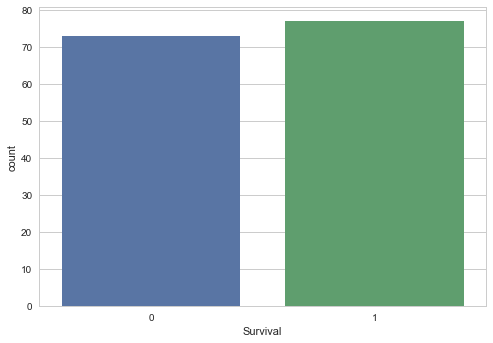

In [31]:
# Visualize counts of classes
survivalbox = sns.countplot(x="Survival", data = s_radiomic_filtered)
survivalbox.set_xlabel('Survival')
fig = survivalbox.get_figure()

## Model building 

In [32]:
%%time

s_master_df = pd.DataFrame(columns = [
    'CLF', 'FSM', 'DN', 
    'AUC_mean', 'AUC_median', 'AUC_std',
    'ACC_mean', 'ACC_median', 'ACC_std',
    'SENS_mean', 'SENS_median', 'SENS_std'
]) # create dataframe where all values will be stored for each combo

for clf in clf_list:
    for score_func in score_func_list:
        for dimension_number in dimension_number_list:
            
            auc_list = [] # Empty lists to be filled 
            accuracy_list = []
            sensitivity_list = []
            
            # Split dataset randomly 100 times 
            for i in range(100):
                train, test = train_test_split(s_radiomic_filtered, test_size = 0.2, random_state=i) 
                survival_classes_train = train['Survival']  
                features_train = train.drop('Survival', axis = 1)
                survival_classes_test = test['Survival'] 
                features_test = test.drop('Survival', axis = 1)
                
                if score_func == 'FILT':
                    clf_pipe = make_pipeline(StandardScaler(), SelectKBest(k=30), clf) # Univariate filtering feature selection method (ANOVA F-score)
                elif score_func == 'PCA':
                    clf_pipe = make_pipeline(StandardScaler(), PCA(n_components=dimension_number, random_state=0), clf) # Ensure all dimensionality reduction methods are set to random states 
                elif score_func == 'KPCA':
                    clf_pipe = make_pipeline(StandardScaler(), KernelPCA(n_components=dimension_number, kernel='sigmoid', random_state=0), clf)
                elif score_func == 'ICA':
                    clf_pipe = make_pipeline(StandardScaler(), FastICA(n_components=dimension_number, random_state=0), clf)
                elif score_func == 'FA':
                    clf_pipe = make_pipeline(StandardScaler(), FactorAnalysis(n_components=dimension_number, random_state=0), clf)
                    
                clf_pipe.fit(features_train, survival_classes_train) # fit with training data only  
                
                auc_list.append(roc_auc_score(survival_classes_test, clf_pipe.predict_proba(features_test)[:,1])) # AUC score NOTE: Predict proba returns a probability per class ("0", "1") so need [:,1] to get positive class
                accuracy_list.append(accuracy_score(survival_classes_test, clf_pipe.predict(features_test))) # accuracy score
                sensitivity_list.append(recall_score(survival_classes_test, clf_pipe.predict(features_test))) # sensitivity list 
                
            s_master_df = s_master_df.append(
                {
                'CLF': str(clf.__class__.__name__), # classifier name
                'FSM': score_func, # score function name 
                'DN': dimension_number, # number of dimensions 
                'AUC_mean': np.mean(auc_list), 
                'AUC_median': np.median(auc_list),
                'AUC_std': np.std(auc_list),
                'RSD': np.std(auc_list)/np.mean(auc_list)*100, # RSD as defined by Parmer et al 2015 
                'ACC_mean': np.mean(accuracy_list),
                'ACC_median': np.median(accuracy_list),
                'ACC_std': np.std(accuracy_list),
                'SENS_mean': np.mean(sensitivity_list),
                'SENS_median': np.median(sensitivity_list),
                'SENS_std': np.std(sensitivity_list)             
                }, ignore_index = True)
            #print s_master_df #debugging 
            if score_func == 'FILT':
                break 

CPU times: user 1h 38min 58s, sys: 3min 19s, total: 1h 42min 18s
Wall time: 59min 5s


In [33]:
s_master_df.head()

CLF   FSM DN  AUC_mean  AUC_median   AUC_std  ACC_mean  \
0  DecisionTreeClassifier  FILT  1  0.522733    0.524943  0.087022  0.523333   
1  DecisionTreeClassifier   PCA  1  0.488001    0.495505  0.092157  0.484667   
2  DecisionTreeClassifier   PCA  3  0.509710    0.500000  0.088737  0.503667   
3  DecisionTreeClassifier   PCA  5  0.518895    0.514706  0.088648  0.514333   
4  DecisionTreeClassifier   PCA  7  0.505982    0.500000  0.089650  0.505000   

   ACC_median   ACC_std  SENS_mean  SENS_median  SENS_std        RSD  
0    0.533333  0.084918   0.533394     0.529412  0.122145  16.647465  
1    0.500000  0.088872   0.506147     0.513158  0.142009  18.884581  
2    0.500000  0.086909   0.520245     0.500000  0.120481  17.409277  
3    0.516667  0.088224   0.531351     0.535897  0.134861  17.084077  
4    0.500000  0.087860   0.523849     0.529412  0.120542  17.717994

## Heatmaps

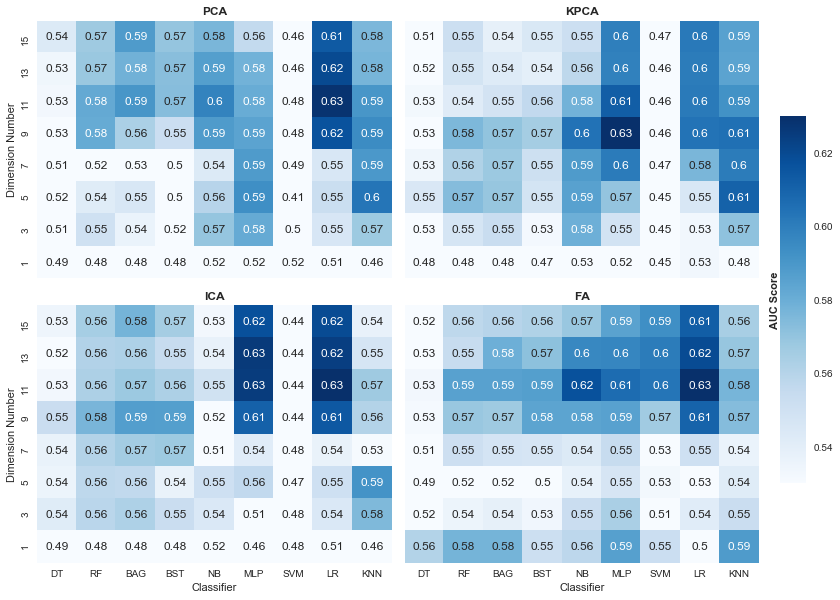

In [50]:
# Predictive performance corresponding to classification methods (in columns) 
# and the number of dimensions (in rows) for each dimensionality reduction 
# method for survival classification task.

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8.5))
cbar_ax = fig.add_axes([.91, .2, .03, .6])

fsm_list = ['PCA', 'KPCA','ICA', 'FA']
for i, (fsm, ax) in enumerate(zip(fsm_list, axn.flat)):
    s_dimensionality_reduction_heatmap_df = pd.DataFrame(index = dimension_number_list, columns = [clf.__class__.__name__ for clf in clf_list])
    for dimension_number in dimension_number_list:
        for clf in clf_list:
            s_dimensionality_reduction_heatmap_df.set_value(dimension_number, clf.__class__.__name__, s_master_df[(s_master_df['DN'] == dimension_number) &
                                                                      (s_master_df['FSM'] == fsm) &
                                                                     (s_master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
    s_dimensionality_reduction_heatmap_df = s_dimensionality_reduction_heatmap_df[s_dimensionality_reduction_heatmap_df.columns].astype(float)
    s_heatmap = sns.heatmap(s_dimensionality_reduction_heatmap_df, ax=ax, cmap = 'Blues', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.53, vmax=0.63, xticklabels=labels, annot= True, cbar=i == 0, cbar_ax=None if i else cbar_ax)
    s_heatmap.invert_yaxis()
    if fsm == 'PCA':
        ax.set_title('PCA',fontweight='bold')
        s_heatmap.set(ylabel='Dimension Number')
        ax.collections[0].colorbar.set_label("AUC Score", fontweight='bold', labelpad=-63)
    elif fsm == 'KPCA':
        ax.set_title('KPCA', fontweight='bold')
    elif fsm == 'ICA':
        ax.set_title('ICA', fontweight='bold')
        s_heatmap.set(xlabel='Classifier', ylabel='Dimension Number')
    elif fsm == 'FA':
        ax.set_title('FA', fontweight='bold')
        s_heatmap.set(xlabel='Classifier')   
fig.tight_layout(rect=[0, 0, .9, 1])
#plt.savefig('survival_heatmap_all.pdf', bbox_inches='tight') # uncomment to save figure

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

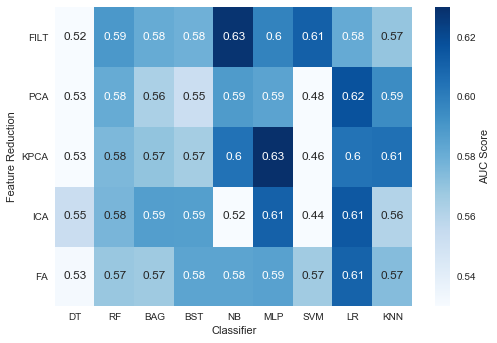

In [35]:
# Heatmap of dimensionality reduction techniques only

s_master_heatmap_df = pd.DataFrame(index = score_func_list, columns = [clf.__class__.__name__ for clf in clf_list])

for score_func in score_func_list:
    for clf in clf_list: 
        if score_func == 'NONE' or score_func == 'FILT':
            s_master_heatmap_df.set_value(score_func, clf.__class__.__name__, s_master_df[(s_master_df['DN'] == 1) &
                                                            (s_master_df['FSM'] == score_func) &
                                                            (s_master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            s_master_heatmap_df = s_master_heatmap_df[s_master_heatmap_df.columns].astype(float)
        else:
            s_master_heatmap_df.set_value(score_func, clf.__class__.__name__, s_master_df[(s_master_df['DN'] == 9) &
                                                            (s_master_df['FSM'] == score_func) &
                                                            (s_master_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            s_master_heatmap_df = s_master_heatmap_df[s_master_heatmap_df.columns].astype(float)

s_heatmap = sns.heatmap(s_master_heatmap_df, cmap = 'Blues', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.53, vmax=0.63, xticklabels=labels, annot= True)
s_heatmap.set(xlabel='Classifier', ylabel='Feature Reduction') 
plt.yticks(rotation=0)

In [36]:
%%time
### Volume feature 

s_volume_df = pd.DataFrame(columns = [
    'CLF', 'FSM', 'DN', 
    'AUC_mean', 'AUC_median', 'AUC_std',
    'ACC_mean', 'ACC_median', 'ACC_std',
    'SENS_mean', 'SENS_median', 'SENS_std'
]) # create dataframe where all values will be stored for each combo)

s_radiomic_filtered_copy = s_radiomic_filtered.copy()

s_radiomic_filtered_copy = s_radiomic_filtered_copy[['Survival', 
                                                 'original_shape_Maximum2DDiameterSlice_necrosis', 
                                                 'original_shape_Maximum2DDiameterSlice_edema', 
                                                 'original_shape_Maximum2DDiameterSlice_enhancing'
                                                ]] # Radiologist approx

for clf in clf_list:
    auc_list = []
    accuracy_list = []
    sensitivity_list = []
    
    for i in range(100):
        train2, test2 = train_test_split(s_radiomic_filtered_copy, test_size = 0.2, random_state=i) 
        survival_classes_train2 = train2['Survival']  
        features_train2 = train2.drop('Survival', axis = 1)
        survival_classes_test2 = test2['Survival'] 
        features_test2 = test2.drop('Survival', axis = 1)
        
        clf_pipe = make_pipeline(StandardScaler(), clf)
        clf_pipe.fit(features_train2, survival_classes_train2)
        
        auc_list.append(roc_auc_score(survival_classes_test2, clf_pipe.predict_proba(features_test2)[:,1])) # AUC score NOTE: Predict proba returns a probability per class ("0", "1") so need [:,1] to get positive class    
        accuracy_list.append(accuracy_score(survival_classes_test2, clf_pipe.predict(features_test2))) # accuracy score
        sensitivity_list.append(recall_score(survival_classes_test2, clf_pipe.predict(features_test2))) # sensitivity list 
                
    s_volume_df = s_volume_df.append({
                'CLF': str(clf.__class__.__name__), # classifier name
                'FSM': 'DIAM', # score function name 
                'DN': 1, # number of dimensions 
                'AUC_mean': np.mean(auc_list), 
                'AUC_median': np.median(auc_list),
                'AUC_std': np.std(auc_list),
                'RSD': np.std(auc_list)/np.mean(auc_list)*100, # RSD as defined by Parmer et al 2015 
                'ACC_mean': np.mean(accuracy_list),
                'ACC_median': np.median(accuracy_list),
                'ACC_std': np.std(accuracy_list),
                'SENS_mean': np.mean(sensitivity_list),
                'SENS_median': np.median(sensitivity_list),
                'SENS_std': np.std(sensitivity_list)             
                }, ignore_index = True)
    #print s_volume_df #debugging 

CPU times: user 43.9 s, sys: 509 ms, total: 44.4 s
Wall time: 32.5 s


In [37]:
s_frames = [s_master_df, s_volume_df]
s_merged_df = pd.concat(s_frames)
s_merged_df

CLF   FSM  DN  AUC_mean  AUC_median   AUC_std  \
0        DecisionTreeClassifier  FILT   1  0.522733    0.524943  0.087022   
1        DecisionTreeClassifier   PCA   1  0.488001    0.495505  0.092157   
2        DecisionTreeClassifier   PCA   3  0.509710    0.500000  0.088737   
3        DecisionTreeClassifier   PCA   5  0.518895    0.514706  0.088648   
4        DecisionTreeClassifier   PCA   7  0.505982    0.500000  0.089650   
5        DecisionTreeClassifier   PCA   9  0.529282    0.533333  0.088602   
6        DecisionTreeClassifier   PCA  11  0.532945    0.535800  0.082291   
7        DecisionTreeClassifier   PCA  13  0.534006    0.527778  0.090406   
8        DecisionTreeClassifier   PCA  15  0.543317    0.533333  0.082497   
9        DecisionTreeClassifier  KPCA   1  0.484465    0.483153  0.088700   
10       DecisionTreeClassifier  KPCA   3  0.527854    0.533333  0.076276   
11       DecisionTreeClassifier  KPCA   5  0.545285    0.542327  0.086610   
12       DecisionTreeClassifier  KPCA   7  0.534214    0.533333  0.095079   
13       DecisionTreeClassifier  KPCA   9  0.528388    0.524943  0.090515   
14       DecisionTreeClassifier  KPCA  11  0.532498    0.533333  0.085085   
15       DecisionTreeClassifier  KPCA  13  0.516335    0.507047  0.093336   
16       DecisionTreeClassifier  KPCA  15  0.510435    0.504525  0.093199   
17       DecisionTreeClassifier   ICA   1  0.488001    0.495505  0.092157   
18       DecisionTreeClassifier   ICA   3  0.542064    0.547321  0.071855   
19       DecisionTreeClassifier   ICA   5  0.535486    0.533333  0.088845   
20       DecisionTreeClassifier   ICA   7  0.537401    0.534825  0.099432   
21       DecisionTreeClassifier   ICA   9  0.553057    0.559028  0.082418   
22       DecisionTreeClassifier   ICA  11  0.532857    0.533635  0.088151   
23       DecisionTreeClassifier   ICA  13  0.516862    0.509050  0.088319   
24       DecisionTreeClassifier   ICA  15  0.534761    0.541667  0.096842   
25       DecisionTreeClassifier    FA   1  0.561228    0.566667  0.091419   
26       DecisionTreeClassifier    FA   3  0.515734    0.524887  0.091571   
27       DecisionTreeClassifier    FA   5  0.487778    0.500000  0.076859   
28       DecisionTreeClassifier    FA   7  0.513595    0.518692  0.089415   
29       DecisionTreeClassifier    FA   9  0.531698    0.527778  0.082639   
30       DecisionTreeClassifier    FA  11  0.532826    0.533333  0.086057   
31       DecisionTreeClassifier    FA  13  0.527309    0.542986  0.090884   
32       DecisionTreeClassifier    FA  15  0.518098    0.520817  0.093620   
33       RandomForestClassifier  FILT   1  0.589684    0.596389  0.091956   
34       RandomForestClassifier   PCA   1  0.476848    0.472851  0.106784   
35       RandomForestClassifier   PCA   3  0.550389    0.559412  0.093279   
36       RandomForestClassifier   PCA   5  0.542064    0.553816  0.094684   
37       RandomForestClassifier   PCA   7  0.515090    0.523472  0.101806   
38       RandomForestClassifier   PCA   9  0.581281    0.594907  0.100965   
39       RandomForestClassifier   PCA  11  0.582082    0.583705  0.098893   
40       RandomForestClassifier   PCA  13  0.568306    0.569367  0.092802   
41       RandomForestClassifier   PCA  15  0.567127    0.559441  0.091513   
42       RandomForestClassifier  KPCA   1  0.482867    0.482361  0.099901   
43       RandomForestClassifier  KPCA   3  0.547550    0.565239  0.091265   
44       RandomForestClassifier  KPCA   5  0.573713    0.576656  0.093857   
45       RandomForestClassifier  KPCA   7  0.561641    0.573236  0.113207   
46       RandomForestClassifier  KPCA   9  0.575657    0.573997  0.103585   
47       RandomForestClassifier  KPCA  11  0.542155    0.538462  0.100301   
48       RandomForestClassifier  KPCA  13  0.548231    0.551133  0.093852   
49       RandomForestClassifier  KPCA  15  0.552064    0.565741  0.095567   
50       RandomForestClassifier   ICA   1  0.476848    0.472851  0.106784   
51       RandomForestCla

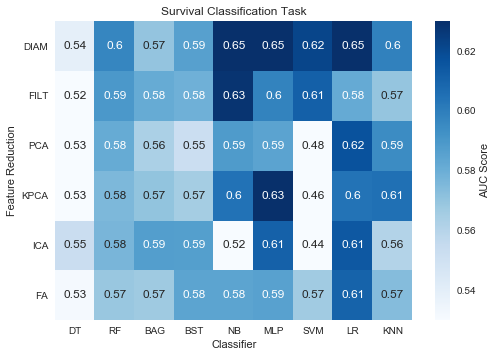

In [49]:
# Heatmap of dimensionality reduction techniques and comparison to diameter

new_score_list2 = ['DIAM', 'FILT', 'PCA', 'KPCA', 'ICA', 'FA']

s_merged_df_heatmap = pd.DataFrame(index = new_score_list2, columns = [clf.__class__.__name__ for clf in clf_list])

for score_func in new_score_list2:
    for clf in clf_list:
        if score_func == 'FILT' or score_func == 'DIAM':
            s_merged_df_heatmap.set_value(score_func, clf.__class__.__name__, s_merged_df[(s_merged_df['DN'] == 1) &
                                                            (s_merged_df['FSM'] == score_func) &
                                                            (s_merged_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            s_merged_df_heatmap = s_merged_df_heatmap[s_merged_df_heatmap.columns].astype(float)
        else:
            s_merged_df_heatmap.set_value(score_func, clf.__class__.__name__, s_merged_df[(s_merged_df['DN'] == 9) &
                                                            (s_merged_df['FSM'] == score_func) &
                                                            (s_merged_df['CLF'] == clf.__class__.__name__)].iloc[0]['AUC_mean']) # actual value
            s_merged_df_heatmap = s_merged_df_heatmap[s_merged_df_heatmap.columns].astype(float)

s_heatmap = sns.heatmap(s_merged_df_heatmap, cmap = 'Blues', cbar_kws={'label': 'AUC Score', 'format': '%.2f'}, vmin=0.53, vmax=0.63, xticklabels=labels, annot= True)
s_heatmap.set(xlabel='Classifier', ylabel='Feature Reduction') 
plt.yticks(rotation=0)
plt.title('Survival Classification Task')
#plt.savefig('survival_heatmap.pdf', bbox_inches='tight') # uncomment to save figure

## Scatterplot

In [39]:
# Representative DF

new_score_list3 = ['PCA', 'KPCA', 'ICA', 'FA']

s_rep_df = pd.DataFrame(index = [clf.__class__.__name__ for clf in clf_list], columns = ['AUC_mean', 'RSD'])

for clf in clf_list:
    for column in s_rep_df.columns:
        s_rep_df.set_value(clf.__class__.__name__, column, 
                        s_master_df[(
                                   (s_master_df.FSM != 'FILT') & 
                                   (s_master_df.CLF == clf.__class__.__name__) & 
                                   (s_master_df.DN == 9))][column].median())
        
s_rep_df.index.name = 'CLF'
s_rep_df = s_rep_df.reset_index()
    
s_rep_df

CLF  AUC_mean      RSD
0      DecisionTreeClassifier   0.53049  16.1413
1      RandomForestClassifier  0.576089  17.6818
2           BaggingClassifier  0.568852  17.8141
3  GradientBoostingClassifier  0.574878  16.5605
4                  GaussianNB  0.586372  17.1639
5               MLPClassifier  0.598402  16.1062
6                         SVC  0.469729  20.2892
7          LogisticRegression  0.612542  15.5416
8        KNeighborsClassifier  0.584137  15.2138

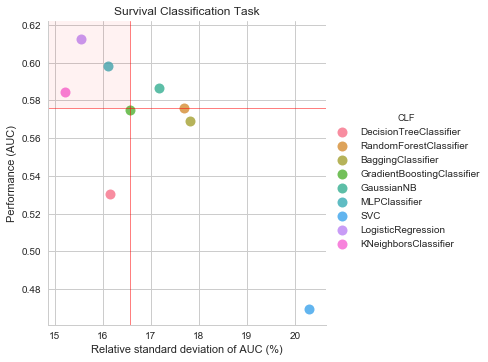

In [55]:
# Averaged Scatter 

# Get median values 
AUC_median = s_rep_df['AUC_mean'].median()
RSD_median = s_rep_df['RSD'].median()

# Create scatterplot
lm = sns.lmplot(
    x="RSD", y="AUC_mean", hue = 'CLF', data = s_rep_df, legend = True, 
    fit_reg=False, scatter_kws={"s": 100}
)

# Set labels
lm.set_ylabels('Performance (AUC)')
lm.set_xlabels('Relative standard deviation of AUC (%)')

# Get axis extrema to draw lines and boxes
axes = plt.gca()
y_min, y_max = axes.get_ylim()
x_min, x_max = axes.get_xlim()

# Plot median lines for AUC and RSD + highlighted area for classifiers with AUC > median and RSD < median
plt.axhline(y= AUC_median, linewidth=1, color = 'red', alpha=0.5)
plt.axvline(x= RSD_median, linewidth=1, color = 'red', alpha=0.5)
lm.axes[0][0].add_patch(patches.Rectangle((x_min, AUC_median), width= (RSD_median-x_min), height=(y_max-AUC_median),facecolor="red", alpha = 0.05))
plt.title('Survival Classification Task')
#plt.savefig("survival_scatter.pdf", bbox_inches='tight') # uncomment to save figure

## ANOVA

In [47]:
# Fit linear model 
s_cw_lm = smf.ols(
    'AUC_mean ~ C(CLF) + C(FSM) + C(DN) + C(CLF)*C(DN) + \
    C(FSM)*C(DN) + C(CLF)*C(FSM)', 
    data=s_master_df[(s_master_df.FSM != 'FILT')] # Drop FILT #Specify C for Categorical
).fit() 

# Create ANOVA from linear model 
s_anova = anova_lm(s_cw_lm, typ=2)
s_anova.index.name = 'Experimental Factors'
s_anova.reset_index(inplace=True)
s_anova['sum_sq'] = s_anova['sum_sq'].apply(lambda x: (x / s_anova['sum_sq'].sum())*100) # Tranform sum sq to % variance
s_anova = s_anova.rename(columns={'sum_sq': '% Variance'}) # Rename to variance 

s_anova 

Experimental Factors  % Variance     df          F        PR(>F)
0               C(CLF)   36.624461    8.0  67.209435  2.084425e-48
1               C(FSM)    2.379755    3.0  11.645548  5.675321e-07
2                C(DN)   19.928920    7.0  41.795999  1.084298e-33
3         C(CLF):C(DN)    9.824412   56.0   2.575535  1.647332e-06
4         C(FSM):C(DN)    8.324374   21.0   5.819441  1.085074e-11
5        C(CLF):C(FSM)   11.474541   24.0   7.018965  2.045805e-15
6             Residual   11.443537  168.0        NaN           NaN

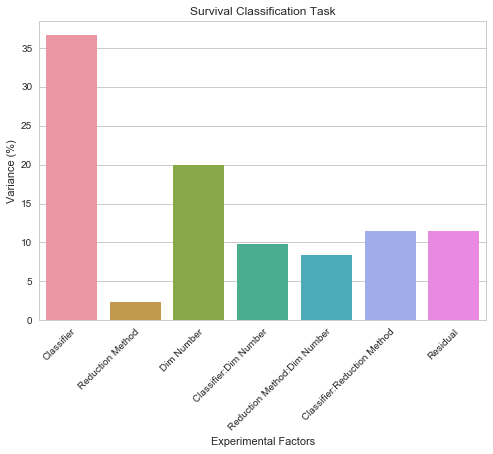

In [48]:
# Creat bar plot for ANOVA factors 
s_anovaplot = sns.barplot(x="Experimental Factors", y="% Variance", data=s_anova)

# Change labels 
s_anovaplot.set_ylabel('Variance (%)')
s_anovaplot.set_xticklabels(['Classifier', 'Reduction Method', 'Dim Number', 'Classifier:Dim Number', \
                           'Reduction Method:Dim Number', 'Classifier:Reduction Method', 'Residual'], ha='right', rotation=45, rotation_mode = 'anchor')

plt.title('Survival Classification Task')
fig = s_anovaplot.get_figure()
#fig.savefig("survival_ANOVA.pdf", bbox_inches='tight') # uncomment to save figure 